In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel

C:\Users\holte\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('features.csv')

In [3]:
df['text_lemmatized'] = df['text_lemmatized'].apply(lambda x: eval(x))
df['title_lemmatized'] = df['title_lemmatized'].apply(lambda x: eval(x))
df['full_text'] = df['title_lemmatized'].apply(lambda tokens: " ".join(tokens)) + " " + df['text_lemmatized'].apply(lambda tokens: " ".join(tokens))

In [4]:
df_trainval, df_test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
df_train, df_val = train_test_split(df_trainval, test_size=0.2, stratify=df_trainval['label'], random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

train_labels = df_train['label'].tolist()
val_labels = df_val['label'].tolist()
test_labels = df_test['label'].tolist()

df_train.to_csv('train.csv')
df_val.to_csv('val.csv')
df_test.to_csv('test.csv')

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model = model.to(device)

Device: cuda


In [6]:
def save_bert_sequence_embeddings(texts, tokenizer, model, output_folder, max_length=256, batch_size=16):
    print("Total texts received:", len(texts))
    os.makedirs(output_folder, exist_ok=True)
    model.eval()

    idx = 0  
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), total=(len(texts) // batch_size) + 1):
            batch_texts = texts[i:i+batch_size]

            inputs = tokenizer(
                batch_texts.tolist(),
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=max_length
            )
            inputs = {key: val.to(device) for key, val in inputs.items()}

            outputs = model(**inputs)
            sequence_output = outputs.last_hidden_state.cpu().half()
            attention_mask = inputs['attention_mask'].cpu()

            for j in range(sequence_output.size(0)):
                np.save(os.path.join(output_folder, f"embedding_{idx}.npy"), sequence_output[j].numpy())
                np.save(os.path.join(output_folder, f"mask_{idx}.npy"), attention_mask[j].numpy())
                idx += 1

            del inputs, outputs, sequence_output, attention_mask
            torch.cuda.empty_cache()

In [7]:
save_bert_sequence_embeddings(texts=df_train['full_text'],tokenizer=tokenizer,model=model,output_folder="train_bert_embeddings",
                              max_length=256,batch_size=16)

Total texts received: 39532


100%|██████████| 2471/2471 [18:48<00:00,  2.19it/s]


In [8]:
save_bert_sequence_embeddings(texts=df_val['full_text'],tokenizer=tokenizer,model=model,output_folder="val_bert_embeddings",
                              max_length=256,batch_size=16)

Total texts received: 9884


  0%|          | 0/618 [00:00<?, ?it/s]

100%|██████████| 618/618 [04:36<00:00,  2.24it/s]


In [9]:
save_bert_sequence_embeddings(texts=df_test['full_text'],tokenizer=tokenizer,model=model,output_folder="test_bert_embeddings",
                             max_length=256,batch_size=16)


Total texts received: 12354


100%|██████████| 773/773 [05:49<00:00,  2.21it/s]


In [10]:
def load_embedding_and_mask(idx, folder_path):
    embedding = np.load(f"{folder_path}/embedding_{idx}.npy")
    mask = np.load(f"{folder_path}/mask_{idx}.npy")

    embedding = torch.tensor(embedding, dtype=torch.float32)
    mask = torch.tensor(mask, dtype=torch.float32)
    
    return embedding, mask

In [11]:
def create_batch(indices, folder_path, labels=None):
    embeddings = []
    masks = []
    batch_labels = []

    for idx in indices:
        embedding, mask = load_embedding_and_mask(idx, folder_path)
        embeddings.append(embedding)
        masks.append(mask)
        if labels is not None:
            batch_labels.append(labels[idx])

    embeddings = torch.stack(embeddings).to(device)
    masks = torch.stack(masks).to(device)

    if labels is not None:
        batch_labels = torch.tensor(batch_labels).to(device)
        return embeddings, masks, batch_labels
    else:
        return embeddings, masks

In [12]:
embedding_dim = 768
hidden_dim = 256
num_classes = 2

lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
linear = nn.Linear(hidden_dim * 2, num_classes)
lstm = lstm.to(device)
linear = linear.to(device)

In [13]:
def evaluate(lstm, linear, folder_path, labels=None, batch_size=16):
    lstm.eval()
    linear.eval()
    
    all_preds = []
    all_labels = []

    num_samples = len(labels) if labels is not None else len(os.listdir(folder_path)) // 2

    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            batch_indices = list(range(i, min(i + batch_size, num_samples)))

            if labels is not None:
                embeddings, masks, batch_labels = create_batch(batch_indices, folder_path, labels)
            else:
                embeddings, masks = create_batch(batch_indices, folder_path)

            outputs, (h_n, c_n) = lstm(embeddings)
            lengths = masks.sum(dim=1) - 1
            last_outputs = outputs[torch.arange(outputs.size(0)), lengths.long()]

            logits = linear(last_outputs)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu())

            if labels is not None:
                all_labels.append(batch_labels.cpu())

    all_preds = torch.cat(all_preds)

    if labels is not None:
        all_labels = torch.cat(all_labels)
        acc = (all_preds == all_labels).float().mean().item()
        print(f"Accuracy: {acc:.4f}")
        return acc
    else:
        return all_preds

In [14]:
history = {'train_loss': [],'train_acc': [],'val_acc': [],'test_acc': []}
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(lstm.parameters()) + list(linear.parameters()), lr=1e-4)
num_epochs = 5
batch_size = 16
train_folder = "train_bert_embeddings"
train_labels = df_train['label'].tolist()

for epoch in range(num_epochs):
    lstm.train()
    linear.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    indices = list(range(len(train_labels)))
    np.random.shuffle(indices)

    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        embeddings, masks, labels = create_batch(batch_indices, train_folder, train_labels)

        optimizer.zero_grad()
        outputs, (h_n, c_n) = lstm(embeddings)

        lengths = masks.sum(dim=1) - 1
        last_outputs = outputs[torch.arange(outputs.size(0)), lengths.long()]
        logits = linear(last_outputs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    train_acc = (torch.cat(all_preds) == torch.cat(all_labels)).float().mean().item()
    val_acc = evaluate(lstm, linear, "val_bert_embeddings", val_labels, batch_size=batch_size)
    test_acc = evaluate(lstm, linear, "test_bert_embeddings", test_labels, batch_size=batch_size)

    history['train_loss'].append(total_loss / (len(indices) / batch_size))
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['test_acc'].append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {history['train_loss'][-1]:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

Accuracy: 0.8861
Accuracy: 0.8837
Epoch 1/5 | Loss: 0.3521 | Train Acc: 0.8410 | Val Acc: 0.8861 | Test Acc: 0.8837
Accuracy: 0.8939
Accuracy: 0.8912
Epoch 2/5 | Loss: 0.2620 | Train Acc: 0.8883 | Val Acc: 0.8939 | Test Acc: 0.8912
Accuracy: 0.9144
Accuracy: 0.9161
Epoch 3/5 | Loss: 0.2276 | Train Acc: 0.9045 | Val Acc: 0.9144 | Test Acc: 0.9161
Accuracy: 0.9385
Accuracy: 0.9393
Epoch 4/5 | Loss: 0.1845 | Train Acc: 0.9263 | Val Acc: 0.9385 | Test Acc: 0.9393
Accuracy: 0.9418
Accuracy: 0.9422
Epoch 5/5 | Loss: 0.1215 | Train Acc: 0.9528 | Val Acc: 0.9418 | Test Acc: 0.9422


In [15]:
y_pred = evaluate(lstm, linear, "test_bert_embeddings", batch_size=16)
y_test = df_test['label'].tolist()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      6883
           1       0.89      0.99      0.94      5471

    accuracy                           0.94     12354
   macro avg       0.94      0.95      0.94     12354
weighted avg       0.95      0.94      0.94     12354



Text(0.5, 1.0, 'Confusion Matrix')

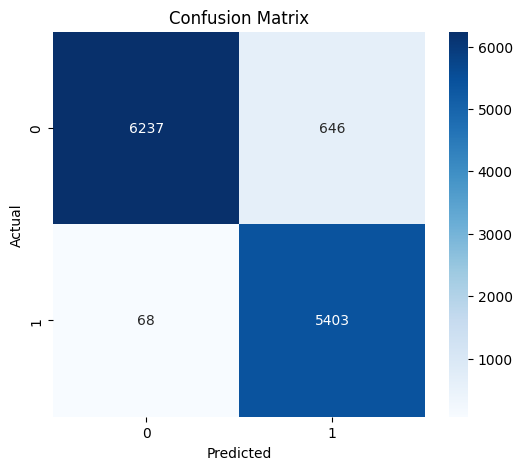

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

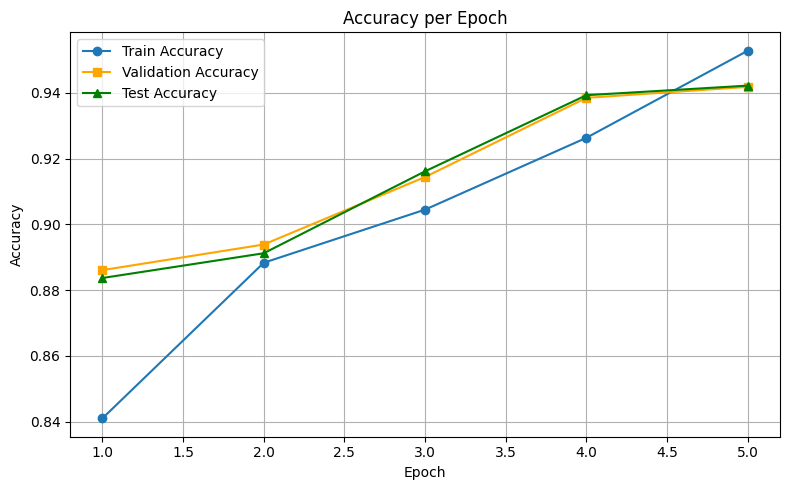

In [17]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='s', color='orange')
plt.plot(epochs, history['test_acc'], label='Test Accuracy', marker='^', color='green')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()

In [18]:
history_df = pd.DataFrame(history)
history_df.to_csv("bert_lstm_history.csv", index=False)

In [19]:
torch.save(lstm.state_dict(), "bert_lstm_model.pt")
torch.save(linear.state_dict(), "bert_lstm_linear.pt")